In [3]:
pip install kaggle

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 60% 9.00M/15.1M [00:00<00:00, 36.2MB/s]
100% 15.1M/15.1M [00:00<00:00, 57.0MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: data/brain_tumor_dataset/no/10 no.jpg  
  inflating: data/brain_tumor_dataset/no/11 no.jpg  
  inflating: data/brain_tumor_dataset/no/12 no.jpg  
  inflating: data/brain_tumor_dataset/no/13 no.jpg  
  inflating: data/brain_tumor_dataset/no/14 no.jpg  
  inflating: data/brain_tumor_dataset/no/15 no.jpg  
  inflating: data/brain_tumor_dataset/no/17 no.jpg  
  inflating: data/brain_tumor_dataset/no/18 no.jpg  
  inflating: data/brain_tumor_dataset/no/19 no.jpg  
  inflating: data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: data/brain_tumor_dataset/no/20 no.jpg  
  inflating: data/brain_tumor_dataset/no/21 no.jpg  
  inflating: data/brain_tumor_dataset/no/22 n

In [6]:
# Set data paths
data_dir = 'data/brain_tumor_dataset'
categories = ['yes', 'no']

In [7]:
import glob
import cv2

In [8]:
# Initialize lists to hold the images and labels
tumor = []
healthy = []

# Load tumor images
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

# Load healthy images
for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [9]:
# Convert lists to numpy arrays
tumor = np.array(tumor)
healthy = np.array(healthy)
All = np.concatenate((healthy, tumor))

In [10]:
healthy.shape

(85, 128, 128, 3)

In [11]:
tumor.shape

(86, 128, 128, 3)

In [12]:
np.random.choice(10, 5, replace=False)

array([2, 5, 4, 8, 3])

#Visualizing the MRI Dataset

In [13]:
import random

In [14]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

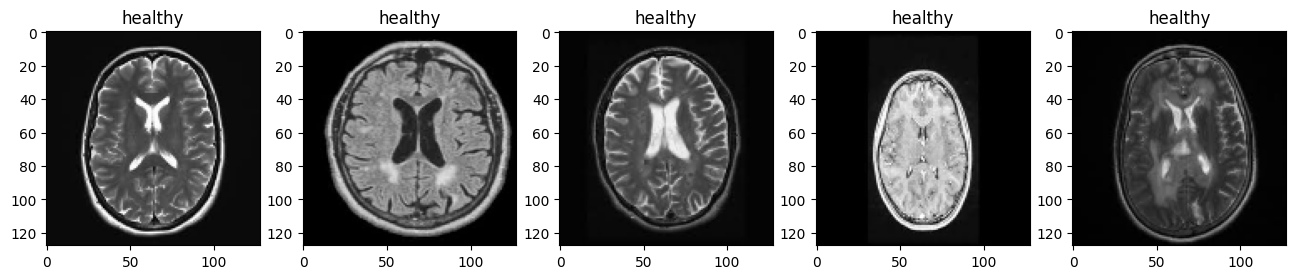

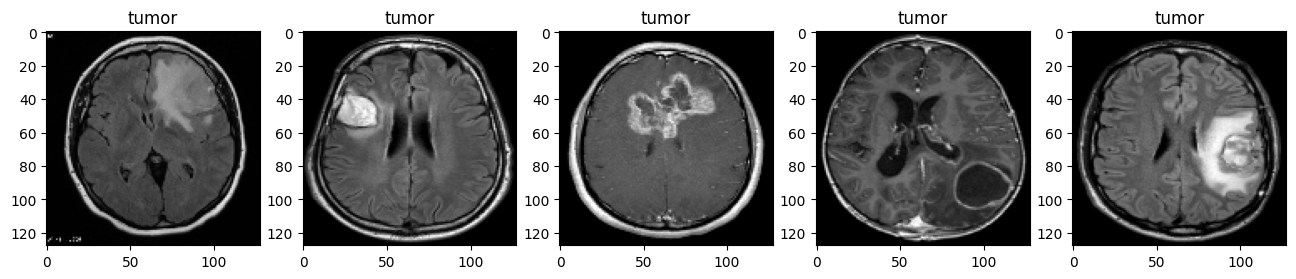

In [15]:
plot_random(healthy, tumor, num=5)

In [16]:
# Create labels
tumor_labels = np.ones(len(tumor))
healthy_labels = np.zeros(len(healthy))

In [17]:
# Combine the data and labels
X = np.concatenate((tumor, healthy), axis=0)
y = np.concatenate((tumor_labels, healthy_labels), axis=0)

In [18]:
# Normalize the data
X = X / 255.0

In [19]:
# Convert labels to categorical
y = to_categorical(y, num_classes=2)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Design a VGG16 Model

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [23]:
def create_vgg16_model(input_shape, num_classes, dropout_rate=0.5):
    # Load VGG16 model without the top layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Add custom layers on top of VGG16 base
    model = Sequential([
        vgg16_base,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Assuming 'categories' is defined and contains the class labels
input_shape = (128, 128, 3)
num_classes = len(categories)
dropout_rate = 0.5  # Hyperparameter

# Create the model
model = create_vgg16_model(input_shape, num_classes, dropout_rate)

58889256/58889256 [==============================] - 1s 0us/step


In [25]:
from tensorflow.keras.optimizers import Adam

In [26]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the Model

In [27]:
# Hyperparameters
batch_size = 32
epochs = 25

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/25
5/5 [==============================] - 38s 7s/step - loss: 1.3622 - accuracy: 0.4632 - val_loss: 0.5434 - val_accuracy: 0.7429
Epoch 2/25
5/5 [==============================] - 36s 8s/step - loss: 0.7782 - accuracy: 0.7132 - val_loss: 0.4264 - val_accuracy: 0.8000
Epoch 3/25
5/5 [==============================] - 34s 7s/step - loss: 0.4678 - accuracy: 0.7500 - val_loss: 0.4382 - val_accuracy: 0.7714
Epoch 4/25
5/5 [==============================] - 30s 6s/step - loss: 0.4183 - accuracy: 0.8235 - val_loss: 0.3727 - val_accuracy: 0.8286
Epoch 5/25
5/5 [==============================] - 33s 7s/step - loss: 0.3242 - accuracy: 0.8603 - val_loss: 0.3612 - val_accuracy: 0.8286
Epoch 6/25
5/5 [==============================] - 35s 7s/step - loss: 0.2908 - accuracy: 0.8897 - val_loss: 0.4035 - val_accuracy: 0.8286
Epoch 7/25
5/5 [==============================] - 31s 7s/step - loss: 0.2130 - accuracy: 0.9485 - val_loss: 0.3399 - val_accuracy: 0.8286
Epoch 8/25
5/5 [==================

#Evaluate the Model

In [28]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 7s 474ms/step - loss: 0.2520 - accuracy: 0.9429
Test Loss: 0.2520318627357483
Test Accuracy: 0.9428571462631226


#Visualize the Training History

In [29]:
import matplotlib.pyplot as plt

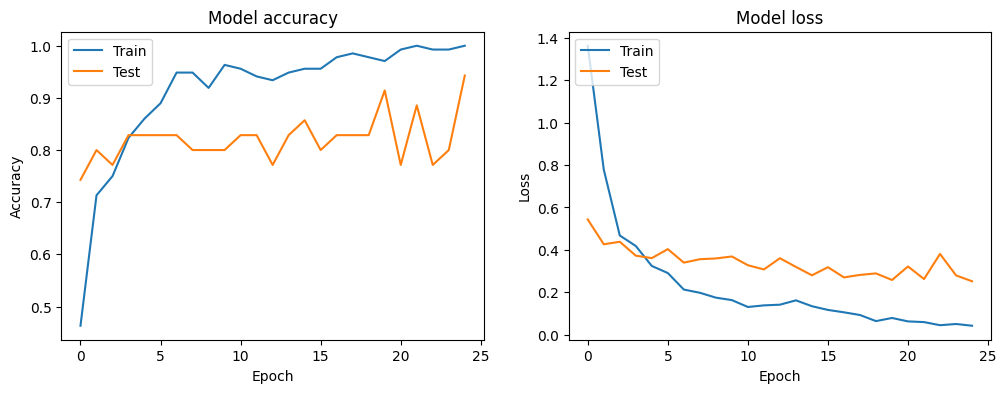

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction and Evaluate using Confusion Matrix

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 6s 446ms/step


<Figure size 800x600 with 0 Axes>

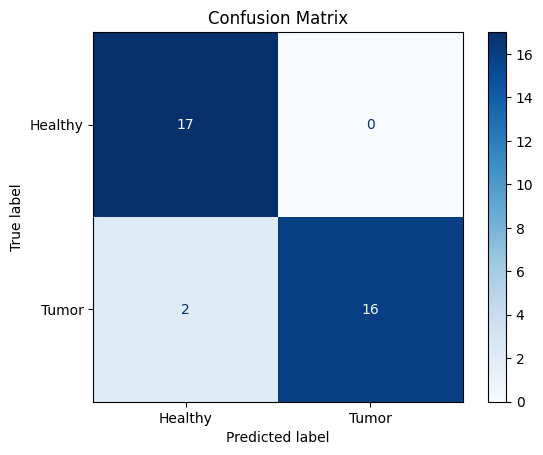

In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()